In [1]:
from simpl_eeg import eeg_objects

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import altair as alt

import mne
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs,
                               compute_proj_ecg, compute_proj_eog)
import scipy.io
import scipy.interpolate
from scipy import signal
from scipy.cluster.hierarchy import (
    average,
    complete,
    dendrogram,
    fcluster,
    single,
    ward,
)

from sklearn import cluster, datasets, metrics
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.datasets import make_moons

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import mglearn

from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
# update figure size
plt.rcParams['figure.figsize'] = [20, 10]

# random state to make results reproducible
random_state = 42

## Introduction

Electroencephalograms (EEG) is an electrophysiological measurement method used to examine the electrical activity of the brain and represent it as location-based channels of waves and frequencies. Essentially, the EEG data from our dataset is recorded from 19 electrodes nodes for 1.5 hours. Therefore, the EEG data is in high dimensionality and could be represented as a multivariate time series data. If we present the data in a tabular format, the number of rows would be the time stamps and the number of columns would be the different electrodes. As we have 1.5 hrs experiment data and each seconds is recorded at 2048 Hz, which means we have 2048 EEG data readings per second, our dataset is large with at least 1 million rows.

## Objectives

EEG data is widely use in diagnosing brain disorders such as epilepsy and brain damage from head injuries, however, with the complexity of data and its dynamic changes over time, it is hard to identify any significant patterns by simply reading the data or visualizing it. The main objective of this strech goal is to find similar patterns from the combination of EEG signals of all 19 electrodes for a given time section from the dataset. In plain English, it is to cluster the brain states for different time periods in the data.

## Selecting EEG data

We can select the data we want to use with the `simpl_eeg` package. We can either look at individual time steps or time steps averaged over time. We can also specify what time to look at.

For more information about making these selections, please see the page on [Creating EEG Objects](https://ubc-mds.github.io/simpl_eeg_capstone/eeg_objects.html) in the `simpl_eeg` documentation. 

Averaging the data has will reduce the dimensionality of the data, but which method you want to use will depend on what you are trying to achieve. 

In [3]:
# experiment we want to use data from
experiment_number = "../../data" #data/exp number

# set the start second if you want to use a custom time
# when the start second is None, the impact times from the experiment will be used. 
start_second = 500
# start_second = None

# the number of seconds before the event to use
tmin = -5

# the number of seconds after the event to use
tmax = 5

epochs = eeg_objects.Epochs(experiment_number, tmin=tmin, tmax=tmax, start_second=start_second)
epoch = epochs.epoch

# the lines below are to average every n steps
# number of steps to average
n = 5

averaged_epoch = epochs.average_n_steps(n)

print("\nDimensionality difference between raw and averaged:")
print(f"Raw: {epoch.get_data().shape}")
print(f"Averaged: {averaged_epoch.get_data().shape}")

Reading C:\Users\mgaro\UBC-MDS\Capstone\simpl_eeg_capstone\data\fixica.fdt
Not setting metadata
Not setting metadata
1 matching events found
Setting baseline interval to [-5.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 20481 original time points ...
0 bad epochs dropped

Dimensionality difference between raw and averaged:
Raw: (1, 19, 20481)
Averaged: (19, 4097)


In [14]:
# Choose which data you want by commenting or uncommenting the lines below:

# selected_var = epoch
selected_var = averaged_epoch

# Convert the data into a dataframe for easy analysis with clustering methods
df = selected_var.to_data_frame()

In [15]:
df

,time,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2
0,-5000,-1.294465,3.946700,-3.538027,7.175086,5.784595,-2.021021,-0.956666,5.650838,-3.144067,1.921047,6.468854,-0.127807,2.429115,3.293074,-3.265165,0.451700,0.520444,9.878809,10.239571
1,-4998,-1.838844,2.288675,-4.980365,0.081897,4.205466,-1.272358,-0.453830,5.371493,0.663698,3.775580,8.283068,2.625821,5.225818,8.885185,-1.586004,3.934649,9.297462,10.823409,14.794802
2,-4995,0.596547,3.840520,-1.034227,7.924566,8.366533,2.972732,5.052248,9.564969,6.170397,9.022112,12.327383,5.977273,9.360542,10.888337,0.431120,5.383598,7.825142,11.107745,11.808467
3,-4993,1.177227,4.606093,0.860214,3.055131,8.555369,5.625031,8.288464,11.422176,5.733884,10.924345,11.589901,6.550682,9.512228,7.908634,-1.361612,3.817698,4.839959,10.940839,6.480374
4,-4990,-0.261840,2.107116,-1.263147,2.714250,9.247147,3.179468,7.179830,10.801949,6.644551,7.651016,9.502653,4.275381,1.803354,5.274124,-2.893799,0.776703,2.317273,11.492387,4.828429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092,4990,3.440347,-0.381364,0.963976,7.548988,9.058421,10.509744,6.406388,16.347849,11.393920,16.819754,16.998933,9.512696,16.862568,21.151777,1.601033,10.303038,18.790268,16.880329,19.224436
4093,4993,4.747082,2.337710,2.693642,-6.350269,-1.134120,8.898355,5.845129,6.664392,7.832503,11.461069,9.872563,4.791656,7.906897,10.990879,1.822345,4.169200,3.825212,4.184695,8.692581
4094,4995,2.167757,-0.724281,-3.556239,10.961161,-4.665130,0.508368,-7.779694,-1.845530,3.891409,3.673469,3.490635,3.124429,6.906742,7.906143,1.233910,4.581886,9.204071,-1.905702,9.145580
4095,4998,3.511185,0.206208,-8.924579,-4.140389,-13.250965,-1.905818,-9.357963,-4.279804,3.208357,2.772302,1.181867,3.112631,6.594071,5.412709,-3.536814,2.593312,2.578132,-10.473685,3.154092


In [16]:
# Drop the time column and convert to array
df.drop(columns = ["time"], inplace=True)
X = df.to_numpy()

In [17]:
X

array([[ -1.29446533,   3.94670024,  -3.53802683, ...,   0.52044354,
          9.87880897,  10.239571  ],
       [ -1.83884398,   2.28867453,  -4.98036515, ...,   9.29746234,
         10.8234092 ,  14.79480222],
       [  0.59654729,   3.84052005,  -1.03422714, ...,   7.82514207,
         11.10774472,  11.80846704],
       ...,
       [  2.16775725,  -0.72428119,  -3.55623884, ...,   9.20407096,
         -1.90570175,   9.14558018],
       [  3.51118494,   0.20620813,  -8.92457931, ...,   2.57813174,
        -10.47368519,   3.15409197],
       [  8.05968672,   0.11447066,   6.51785578, ...,   4.76206611,
         -3.88973737,   8.26532879]])

In [8]:
pip install minisom

  Using cached MiniSom-2.2.9.tar.gz (8.1 kB)
  Created wheel for minisom: filename=MiniSom-2.2.9-py3-none-any.whl size=8603 sha256=8b08f22ffdeb7d68ea16f34a1f997ea1690a2bbd9f257cff28055b01b86744e4
  Stored in directory: c:\users\mgaro\appdata\local\pip\cache\wheels\f7\c1\13\a89711e5641aedaacbfe71023fba586b9b45d848d3b02192f8
Successfully built minisom
Note: you may need to restart the kernel to use updated packages.


In [9]:
from minisom import MiniSom 

In [ ]:
# Normlizing the data

data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

In [18]:
df

,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2
0,-1.294465,3.946700,-3.538027,7.175086,5.784595,-2.021021,-0.956666,5.650838,-3.144067,1.921047,6.468854,-0.127807,2.429115,3.293074,-3.265165,0.451700,0.520444,9.878809,10.239571
1,-1.838844,2.288675,-4.980365,0.081897,4.205466,-1.272358,-0.453830,5.371493,0.663698,3.775580,8.283068,2.625821,5.225818,8.885185,-1.586004,3.934649,9.297462,10.823409,14.794802
2,0.596547,3.840520,-1.034227,7.924566,8.366533,2.972732,5.052248,9.564969,6.170397,9.022112,12.327383,5.977273,9.360542,10.888337,0.431120,5.383598,7.825142,11.107745,11.808467
3,1.177227,4.606093,0.860214,3.055131,8.555369,5.625031,8.288464,11.422176,5.733884,10.924345,11.589901,6.550682,9.512228,7.908634,-1.361612,3.817698,4.839959,10.940839,6.480374
4,-0.261840,2.107116,-1.263147,2.714250,9.247147,3.179468,7.179830,10.801949,6.644551,7.651016,9.502653,4.275381,1.803354,5.274124,-2.893799,0.776703,2.317273,11.492387,4.828429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092,3.440347,-0.381364,0.963976,7.548988,9.058421,10.509744,6.406388,16.347849,11.393920,16.819754,16.998933,9.512696,16.862568,21.151777,1.601033,10.303038,18.790268,16.880329,19.224436
4093,4.747082,2.337710,2.693642,-6.350269,-1.134120,8.898355,5.845129,6.664392,7.832503,11.461069,9.872563,4.791656,7.906897,10.990879,1.822345,4.169200,3.825212,4.184695,8.692581
4094,2.167757,-0.724281,-3.556239,10.961161,-4.665130,0.508368,-7.779694,-1.845530,3.891409,3.673469,3.490635,3.124429,6.906742,7.906143,1.233910,4.581886,9.204071,-1.905702,9.145580
4095,3.511185,0.206208,-8.924579,-4.140389,-13.250965,-1.905818,-9.357963,-4.279804,3.208357,2.772302,1.181867,3.112631,6.594071,5.412709,-3.536814,2.593312,2.578132,-10.473685,3.154092


In [25]:
dft = df.T
dft

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
Fp1,-1.294465,-1.838844,0.596547,1.177227,-0.261840,-0.731008,1.469891,1.781809,1.502867,2.950112,...,5.077780,4.694118,9.427269,5.853040,3.407263,3.440347,4.747082,2.167757,3.511185,8.059687
Fp2,3.946700,2.288675,3.840520,4.606093,2.107116,-0.055748,-0.089680,-0.534591,4.275456,4.752558,...,-2.481646,-1.980618,0.367237,1.091680,0.973849,-0.381364,2.337710,-0.724281,0.206208,0.114471
F7,-3.538027,-4.980365,-1.034227,0.860214,-1.263147,-4.950815,-1.183451,3.613397,-1.653739,4.115596,...,4.367044,9.837066,15.027575,0.222545,-0.633838,0.963976,2.693642,-3.556239,-8.924579,6.517856
T3,7.175086,0.081897,7.924566,3.055131,2.714250,0.882930,5.337939,12.344353,0.183902,1.166754,...,-26.716729,21.367136,20.278415,12.693773,13.824397,7.548988,-6.350269,10.961161,-4.140389,-5.200542
T5,5.784595,4.205466,8.366533,8.555369,9.247147,4.503834,7.609192,11.533149,3.884392,6.744441,...,-5.144601,10.554880,13.857051,-0.193836,1.273123,9.058421,-1.134120,-4.665130,-13.250965,-2.483385
F3,-2.021021,-1.272358,2.972732,5.625031,3.179468,1.914818,4.648132,6.789684,3.576825,9.214995,...,8.139784,9.154686,18.677617,5.218651,4.879622,10.509744,8.898355,0.508368,-1.905818,11.282695
C3,-0.956666,-0.453830,5.052248,8.288464,7.179830,2.068618,5.156762,9.311420,4.705301,11.169411,...,8.960329,6.242345,15.425246,-1.308072,-3.932480,6.406388,5.845129,-7.779694,-9.357963,9.725581
P3,5.650838,5.371493,9.564969,11.422176,10.801949,9.045967,12.291377,15.130152,8.615223,10.853592,...,5.332390,12.071577,20.243341,6.816288,4.935502,16.347849,6.664392,-1.845530,-4.279804,7.086129
Fz,-3.144067,0.663698,6.170397,5.733884,6.644551,5.869122,7.036295,8.233971,5.553890,9.438278,...,4.427564,4.324002,12.929584,4.531970,4.039998,11.393920,7.832503,3.891409,3.208357,11.151980
Cz,1.921047,3.775580,9.022112,10.924345,7.651016,6.968887,8.750315,11.481880,10.420736,14.170119,...,5.693393,9.450117,21.945341,10.308565,8.026178,16.819754,11.461069,3.673469,2.772302,12.586581


In [55]:
electrodes = np.array(df.columns)
electrodes

array(['Fp1', 'Fp2', 'F7', 'T3', 'T5', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz',
       'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O1', 'O2'], dtype=object)

In [56]:
lobes = [x[:-1] for x in electrodes]
lobes

['Fp',
 'Fp',
 'F',
 'T',
 'T',
 'F',
 'C',
 'P',
 'F',
 'C',
 'P',
 'F',
 'C',
 'P',
 'F',
 'T',
 'T',
 'O',
 'O']

In [30]:
dft=dft.values

In [31]:
som = MiniSom(9, 9, dft.shape[1], sigma=1.5, learning_rate=.5, neighborhood_function='gaussian', random_seed=0)

##### To see the effect of diffrent parameters values, please check this interactive dashboard [here](https://share.streamlit.io/justglowing/minisom/dashboard/dashboard.py)

In [32]:
som.pca_weights_init(dft)

In [33]:
som.train(dft, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 40.78787966143234


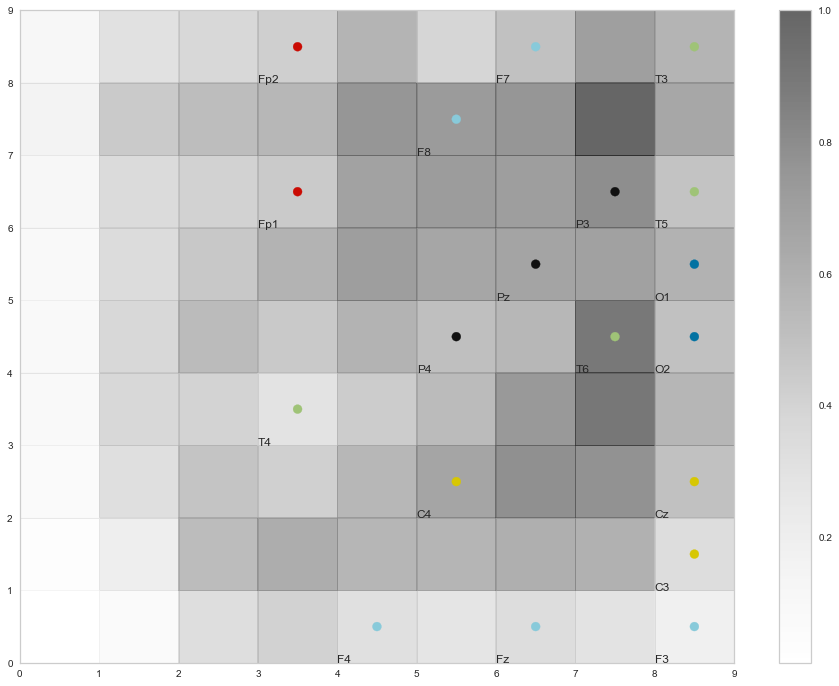

In [92]:
w_x, w_y = zip(*[som.winner(d) for d in dft])
w_x = np.array(w_x)
w_y = np.array(w_y)

electrodes = np.array(df.columns)
lobes = [x[:-1] for x in electrodes]

colormap = {'Fp' : 'r', 'F': 'c', 'O': 'b', 'T': 'g', 'C': 'y', 'P':'k'}
colors = [colormap[lobe] for lobe in lobes]

plt.figure(figsize=(16, 12))
plt.pcolor(som.distance_map().T, cmap='Greys', alpha=.6)
plt.colorbar()
plt.scatter(w_x+0.5, w_y+0.5, label = lobes, c = colors, s=80)

for x, y, text in zip(w_x, w_y, df.columns): 
    plt.text(x, y, text)
# plt.scatter(w_x+0.5+(np.random.rand(len(w_x))-0.5)*.8, w_y+0.5+(np.random.rand(len(w_y))-0.5)*.8, label = df.columns)
plt.grid()
plt.show()

Trying diffrent paramters

In [96]:
param_grid = {'x': [5,10,15,20,30], 'learning_rate': [0.05,0.1,0.2,0.5],'neighborhood_function':['gaussian'], 'sigma':[0.1,0.5,1,10,50,100]}

In [101]:
som.quantization_error(dft)

40.78787966143234

In [105]:
from sklearn.model_selection import ParameterSampler
param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=0))
scores = []
for p in param_list:
    som = MiniSom(p['x'], p['x'], dft.shape[1], sigma=p['sigma'], learning_rate=p['learning_rate'], neighborhood_function=p['neighborhood_function'], random_seed=0)
    print('pca', p)
    som.pca_weights_init(dft)
    print('training', p)
    som.train(dft, 500, verbose=True)
    scores += som.quantization_error(dft)

pca {'x': 20, 'sigma': 10, 'neighborhood_function': 'gaussian', 'learning_rate': 0.1}
training {'x': 20, 'sigma': 10, 'neighborhood_function': 'gaussian', 'learning_rate': 0.1}
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 221.3746943740091
pca {'x': 30, 'sigma': 0.1, 'neighborhood_function': 'gaussian', 'learning_rate': 0.5}
training {'x': 30, 'sigma': 0.1, 'neighborhood_function': 'gaussian', 'learning_rate': 0.5}
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 392.95256775293984
pca {'x': 5, 'sigma': 0.5, 'neighborhood_function': 'gaussian', 'learning_rate': 0.5}
training {'x': 5, 'sigma': 0.5, 'neighborhood_function': 'gaussian', 'learning_rate': 0.5}
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 221.3880648349303
pca {'x': 20, 'sigma': 0.5, 'neighborhood_function': 'gaussian', 'learning_rate': 0.05}
training {'x': 20, 'sigma': 0.5, 'neighborhood_function': 'gaussian', 'learning_rate': 0.05}
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 443

In [106]:
scores

array([], dtype=float64)

In [ ]:
dummy = DummyClassifier(strategy='stratified')
results['Dummy'] = mean_std_cross_val_scores(dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric)
results

In [ ]:
resultclassifier = {}

for (name, model) in param_list.items():   
    resultclassifier[score] = mean_std_cross_val_scores(model, X_train, y_train, return_train_score=True, scoring=scoring_metric)
    
pd.DataFrame(resultclassifier)

#### Results



In [35]:
som.winner(dft[0])

(3, 6)

In [75]:
np.unique(lobes)

array(['C', 'F', 'Fp', 'O', 'P', 'T'], dtype='<U2')